In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Nov 12 16:54:32 2022

@author: Shu-wei Huang
"""

# Load trained models
from keras.models import load_model

model1 = load_model('CNN_DenseNet169.h5')
model2 = load_model('CNN_ResNet152.h5')
model3 = load_model('CNN_vgg19.h5')
model4 = load_model('CNN_InceptionV3.h5')

# Load fingers' images and labels
import numpy as np 
data = np.load(r"data\x_test_image.npz")
x_test_image = data['a']
data.close()

data = np.load(r"data\y_test_label_cat.npz")
y_test_label_cat = data['a']
data.close()

# Ensemble model
ensemble_mdl = [model1, model2, model3, model4]
# do prediction of ensemble model
preds = [model.predict(x_test_image) for model in ensemble_mdl]
preds = np.array(preds)
summed = np.sum(preds, axis=0)
ensemble_prediction = np.argmax(summed, axis=1)

# do prediction (model1, model2, model3 and model4)
prediction1 = np.argmax(model1.predict(x_test_image), axis=1)
prediction2 = np.argmax(model2.predict(x_test_image), axis=1)
prediction3 = np.argmax(model3.predict(x_test_image), axis=1)
prediction4 = np.argmax(model4.predict(x_test_image), axis=1)

# measure/compute accuracy
from sklearn.metrics import accuracy_score

y_test_label = np.argmax(y_test_label_cat, axis=1)

accuracy1 = accuracy_score(y_test_label, prediction1)
accuracy2 = accuracy_score(y_test_label, prediction2)
accuracy3 = accuracy_score(y_test_label, prediction3)
accuracy4 = accuracy_score(y_test_label, prediction4)
ensemble_accuracy = accuracy_score(y_test_label, ensemble_prediction)

print('Accuracy Score for model1 (DenseNet169) = ', accuracy1)
print('Accuracy Score for model2 (ResNet152)   = ', accuracy2)
print('Accuracy Score for model3 (Vgg19)       = ', accuracy3)
print('Accuracy Score for model4 (InceptionV3) = ', accuracy4)
print('Accuracy Score for average ensemble     = ', ensemble_accuracy)


26/26 [==============================] - 41s 2s/step
Accuracy Score for model1 (DenseNet169) =  0.9354445797807551
Accuracy Score for model2 (ResNet152)   =  0.9293544457978076
Accuracy Score for model3 (Vgg19)       =  0.9110840438489647
Accuracy Score for model4 (InceptionV3) =  0.8976857490864799
Accuracy Score for average ensemble     =  0.9427527405602923


In [2]:
# Weighted ensemble model
# Grid search for finding the best weights that provide the optimal accuracy
import pandas as pd
df = pd.DataFrame([])

for w1 in range(0,10):
    for w2 in range(0,10):
        for w3 in range(0,10):
            for w4 in range(0,10):
                wts = [w1/10.,w2/10.,w3/10.,w4/10.]
                wted_preds = np.tensordot(preds, wts, axes=((0),(0)))
                wted_ensemble_pred = np.argmax(wted_preds, axis=1)
                weighted_accuracy = accuracy_score(y_test_label, wted_ensemble_pred)
                df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                             'wt3':wts[2], 'wt4':wts[3],
                                             'acc':weighted_accuracy*100},
                                             index=[0]), ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[4], " obained with w1=", max_acc_row[0],
      " w2=", max_acc_row[1], " w3=", max_acc_row[2] , " and w4=", max_acc_row[2])   

print(max_acc_row.head())

Max accuracy of  95.00609013398295  obained with w1= 0.3  w2= 0.2  w3= 0.3  and w4= 0.3
wt1     0.30000
wt2     0.20000
wt3     0.30000
wt4     0.10000
acc    95.00609
Name: 3231, dtype: float64


In [3]:
# apply weights on the ensemble model
ideal_weights = [0.3, 0.2, 0.3, 0.1] 
weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(y_test_label, weighted_ensemble_prediction)

print('Accuracy Score for model1 (DenseNet169) = ', accuracy1)
print('Accuracy Score for model2 (ResNet152)   = ', accuracy2)
print('Accuracy Score for model3 (Vgg19)       = ', accuracy3)
print('Accuracy Score for model4 (InceptionV3) = ', accuracy4)
print('Accuracy Score for average ensemble     = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)


Accuracy Score for model1 (DenseNet169) =  0.9354445797807551
Accuracy Score for model2 (ResNet152)   =  0.9293544457978076
Accuracy Score for model3 (Vgg19)       =  0.9110840438489647
Accuracy Score for model4 (InceptionV3) =  0.8976857490864799
Accuracy Score for average ensemble     =  0.9427527405602923
Accuracy Score for weighted average ensemble =  0.9500609013398295


([<matplotlib.axis.XTick at 0x22dcf8dd970>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6')])

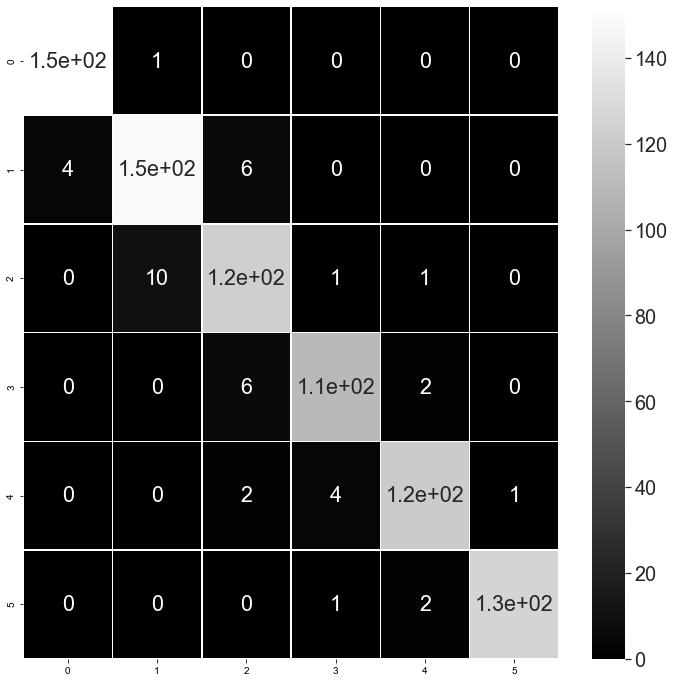

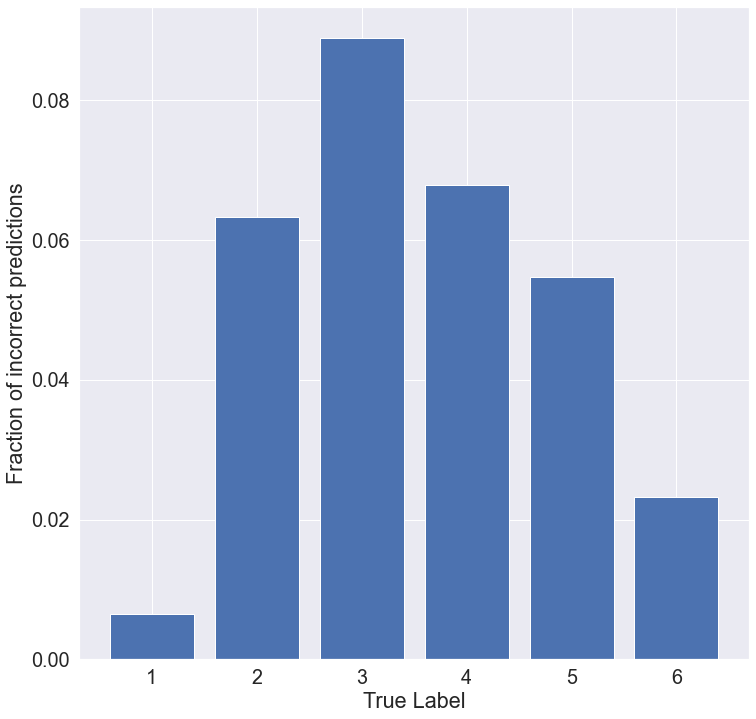

In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
#Print confusion matrix
cm = confusion_matrix(y_test_label, weighted_ensemble_prediction)

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.8)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax, cmap='gray')


# PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
fig, ax = plt.subplots(figsize=(12,12))
plt.bar(np.arange(6), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.xticks(np.arange(6), ['1','2','3','4','5','6']) 